### Fit a detector
- copy boiler plate code. This shouldnt take too long

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [3]:
from typing import List, Dict, Union, Callable, Tuple
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from tqdm.auto import tqdm
from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc
import builtins
from copy import deepcopy


## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur

sys.path.append('../')
from data_utils import get_train_loader, get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.score_adapter import (
    get_score_prediction_modification, 
    fit_score_prediction_modification,
)
# from model.regression_models import ScorePredictor

# from model.wrapper import ScorePredictionWrapper


from matplotlib.colors import ListedColormap, Normalize

def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]


# Create a custom colormap - transparent for class 0, and different colors for other classes
seg_colors = ['none', 'yellow', 'green', 'blue']  # 'none' for transparent
err_colors = ['none', 'red']
seg_cmap = ListedColormap(seg_colors)
err_cmap = ListedColormap(err_colors)

# Ensure the colormap is normalized to the number of classes
seg_norm = Normalize(vmin=0, vmax=len(seg_colors)-1)
err_norm = Normalize(vmin=0, vmax=len(err_colors)-1)



/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [4]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [7]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_all'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda().eval()

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [179]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = ['A'] #
cfg.data.heart.mnm.selection = 'non_empty_target' # 'all_cases' #'non_empty_target'

data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

dataloader = DataLoader(
    data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties
loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'val', 'A']


In [7]:
cfg.run.transform_key = 'all_transforms'
train_loader, valid_loader = get_train_loader(cfg=cfg, training='unet')

loading dataset
loading all case properties


loading dataset
loading all case properties


In [53]:
from torchmetrics.functional.classification import ( # type: ignore
    dice,
    multiclass_accuracy
)
from torch import ( # type: ignore
    stack
)
from typing import (
    List, 
    Callable, 
    Tuple
)
from torch import ( # type: ignore
    nn, 
    no_grad, 
    Tensor, 
    nan_to_num, 
    argmax, 
    stack, 
    flatten, 
    sigmoid
)
from torch.utils.data import DataLoader  # type: ignore
from torch.optim import Adam  # type: ignore
from torchmetrics.functional.classification import dice  # type: ignore
from tqdm import tqdm  # type: ignore
from copy import deepcopy

from utils import find_shapes_for_swivels




def fit_score_prediction_modification(
    wrapper: nn.Module,
    dataloader: DataLoader,
    prediction_head: bool,
    scores: List[str],
    lr: float = 1e-6,
    epochs: int = 2500,
    device: str = 'cuda:0'
):
    wrapper.freeze_normalization_layers()
    wrapper.adapters.train()
    loss_collection = LossCollection()

    optimizer    = Adam(wrapper.parameters(), lr=lr)
    loss_cache   = []
    progress_bar = tqdm(range(epochs), total=epochs, position=0, leave=True)

    for i in progress_bar:
        
        batch  = next(dataloader)
        input  = batch['data'].to(device)
        target = batch['target'].long().to(device)
        target[target == -1] = 0
        logits = wrapper(input)
        preds = argmax(logits, dim=1, keepdim=True)
        if prediction_head:
            prediction = wrapper.prediction.unsqueeze(1)

        else:
            prediction = wrapper.output_per_adapter

        optimizer.zero_grad()
        loss = 0
        loss_dict = {}
        if 'dice' in scores:
            loss_dice = loss_collection.dice_per_class_loss(
                predicted_segmentation=preds, 
                target_segmentation=target,
                prediction=prediction[:, :, :4]
            )
            loss += loss_dice.sum(1).mean()
            loss_dict['dice'] = loss_dice.detach().cpu()


        if 'acc' in scores:
            loss_acc = loss_collection.acc_per_class_loss(
                predicted_segmentation=preds, 
                target_segmentation=target,
                prediction=prediction[:, :, 4:8]
            )
            loss += loss_acc.sum(1).mean()
            loss_dict['acc'] = loss_acc.detach().cpu()


        if 'fcd' in scores:
            loss_fcd = loss_collection.foreground_class_distribution_loss(
                target_segmentation=target,
                prediction=prediction[:, :, 8:11]
            )
            loss += loss_fcd.sum(1).mean()
            loss_dict['fcd'] = loss_fcd.detach().cpu()


        if 'fce' in scores:
            loss_fce = loss_collection.foreground_class_existance_loss(
                target_segmentation=target,
                prediction=sigmoid(prediction[:, :, 11:14])
            )
            loss += loss_fce.sum(1).mean()
            loss_dict['fce'] = loss_fce.detach().cpu()
            
        
        loss.backward()
        optimizer.step()

        loss_cache.append(loss_dict)        
        # loss_cache.append(loss.data.detach().cpu())
        epoch_summary = ""
        for key, value in loss_dict.items():
            epoch_summary += f'{key}: {value.sum(1).mean().item():.4f} |'
        epoch_summary += f" Progress"
        progress_bar.set_description("".join(epoch_summary))


    wrapper.eval()

    return loss_cache



def get_score_prediction_modification(
    swivels: List[str],
    unet: nn.Module,
    adapter_output_dim: int = 16,
    attach_prediction_head: bool = True,
    prediction_head_output_dim: int = 4,
    transform: bool = False,
    lr: float = 1e-3,
    return_state_dict: bool = False,
    device: str = 'cuda:0'
):
    
    # init prediction head
    if attach_prediction_head:
        prediction_head = PredictionHead(
            input_dim=len(swivels) * adapter_output_dim,
            output_dim=prediction_head_output_dim
        )
    else:
        prediction_head = None

    output_shapes = find_shapes_for_swivels(unet, swivels)
    # init detectors with corresponding predictors
    score_detectors = [
        ScorePredictionAdapter(
            swivel=swivel,
            predictor=ScorePredictor(
                input_size=output_shapes[swivel],
                output_dim=adapter_output_dim
            ),
            lr = lr,
            transform = transform,
        ) for swivel in swivels
    ]
    # wrap the model with the detectors
    wrapper = ScorePredictionWrapper(
        model=unet,
        prediction_head=prediction_head,
        adapters=nn.ModuleList(score_detectors),
        copy=True
    )
    wrapper.freeze_model()
    wrapper.to(device)

    if return_state_dict:
        raise NotImplementedError
    
    return wrapper



class PredictionHead(nn.Module):
    def __init__(
            self, 
            input_dim, 
            output_dim
        ):
        super(PredictionHead, self).__init__()
        hidden_dim = input_dim // 4
        # Define the first fully connected layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Define Layer Normalization for the first layer
        self.ln1 = nn.LayerNorm(hidden_dim)
        # Leaky ReLU activation function for the first layer
        self.leaky_relu1 = nn.LeakyReLU(negative_slope=0.01)
        
        # Define the second fully connected layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Define Layer Normalization for the second layer
        self.ln2 = nn.LayerNorm(hidden_dim)
        # Leaky ReLU activation function for the second layer
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.01)
        
        # Define the third fully connected layer (output layer)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Forward pass through the first layer, normalization, and activation
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.leaky_relu1(x)
        
        # Forward pass through the second layer, normalization, and activation
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.leaky_relu2(x)
        
        # Output layer (no activation here if it's a regression task or depending on the task)
        x = self.fc3(x)
        
        return x



class ScorePredictor(nn.Module):
    """
    A simple model to predict a score based on a DNN activation.

    Args:
    - input_size (list): The size of the input tensor
    - hidden_dim (int): The size of the hidden layer
    - output_dim (int): The size of the output layer
    - dropout_prob (float): The probability of dropout

    Returns:
    - output (torch.Tensor): The output of the model
    """
    def __init__(
        self, 
        input_size: list, 
        hidden_dim: int = 128, 
        output_dim: int = 1, 
        dropout_prob=0.3
    ):
        super(ScorePredictor, self).__init__()
        
        # 1x1 Conv Layer to reduce the number of input channels by a factor of 8
        self.conv1x1 = nn.Conv2d(
            in_channels=input_size[1], 
            out_channels=input_size[1] // 8, 
            kernel_size=1
        )

        self.conv2x2_1 = nn.Conv2d(
            in_channels=input_size[1] // 8,
            out_channels=input_size[1] // 8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.LeakyReLU()
        self.bn1 = nn.BatchNorm2d(input_size[1] // 8)

        self.conv2x2_2 = nn.Conv2d(
            in_channels=input_size[1] // 8,
            out_channels=input_size[1] // 8,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.relu = nn.LeakyReLU()
        self.bn2 = nn.BatchNorm2d(input_size[1] // 8)
        
        # Activation, Norm, Dropout
        self.activation1 = nn.LeakyReLU()  # You can also use other activations like Swish or LeakyReLU
        self.norm1 = nn.BatchNorm2d(input_size[1] // 8)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        # Compute flattened size after convolution for the linear layers
        conv_output_size = input_size[1] * input_size[2]*input_size[3] // 8
        
        # Fully connected layer to reduce the output of the conv to hidden_dim
        self.fc1 = nn.Linear(conv_output_size, hidden_dim)
        self.activation2 = nn.LeakyReLU()
        self.norm2 = nn.LayerNorm(hidden_dim)
        
        # Final fully connected layer to output_dim
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass through 1x1 convolution, activation, normalization, and dropout
        x = self.conv1x1(x)

        x = self.relu(x)
        x = self.bn1(x)
        x = self.conv2x2_1(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.conv2x2_2(x)

        x = self.activation1(x)
        x = self.norm1(x)
        x = self.dropout1(x)
        
        # Flatten the output from the conv layer
        x = flatten(x, start_dim=1)
        
        # Fully connected layer to hidden_dim
        x = self.fc1(x)
        x = self.activation2(x)
        x = self.norm2(x)
        
        # Final output layer
        output = self.fc2(x)
        return output #sigmoid(output)



class ScorePredictionAdapter(nn.Module):
    def __init__(
        self,
        swivel: str,
        predictor: nn.Module,
        train_lr: float = 1e-3,
        lr: float = 1e-3,
        transform: bool = False,
        device: str = 'cuda:0'
    ):
        super().__init__()
        self.swivel = swivel
        self.predictor = predictor
        self.train_lr = train_lr
        self.lr = lr
        self.transform = transform
        self.device = device
        self.active = True

        self.to(device)
        self.score_collection = []


    @no_grad()
    def _collect(
        self, 
        x: Tensor
    ) -> None:
        # reduces dimensionality as per self._pool, moves to cpu and stores
        x = self.predictor(x.detach()).cpu()
        self.score_collection.append(x)


    def on(self):
        self.active = True


    def off(self):
        self.active = False


    def forward(
        self,
        x: Tensor
    ) -> Tensor:
        # this adapter only operates of turned on
        if self.active:
            if self.transform:
                assert not self.training
                x = x.clone().detach().requires_grad_(True)
                self.score = self.predictor(x).sum()
                self.score.backward()
                x.grad.data = nan_to_num(x.grad.data, nan=0.0)
                x.data.sub_(self.lr * x.grad.data)
                x.grad.data.zero_()
                x.requires_grad = False

            else:
                self.score = self.predictor(x)

        else:
            pass
        return x



class ScorePredictionWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        prediction_head: nn.Module,
        adapters: nn.ModuleList,
        copy: bool = True,
    ):
        super().__init__()
        self.model           = deepcopy(model) if copy else model
        self.prediction_head = prediction_head
        self.adapters        = adapters
        self.adapter_handles = {}
        self.transform       = False
        self.model.eval()

        self.hook_adapters()


    def hook_adapters(
        self,
    ) -> None:
        assert self.adapter_handles == {}, "Adapters already hooked"
        for adapter in self.adapters:
            swivel = adapter.swivel
            layer  = self.model.get_submodule(swivel)
            hook   = self._get_hook(adapter)
            self.adapter_handles[
                swivel
            ] = layer.register_forward_pre_hook(hook)


    def _get_hook(
        self,
        adapter: nn.Module
    ) -> Callable:
        def hook_fn(
            module: nn.Module, 
            x: Tuple[Tensor]
        ) -> Tensor:
            # x, *_ = x # tuple, alternatively use x_in = x[0]
            # x = adapter(x)
            return adapter(x[0])
        
        return hook_fn
    

    def set_transform(self, transform: bool):
        self.transform = transform
        for adapter in self.adapters:
            adapter.transform = transform


    def set_train_lr(self, train_lr):
        for adapter in self.adapters:
            adapter.train_lr = train_lr


    def set_train_lr(self, inference_lr):
        for adapter in self.adapters:
            adapter.inference_lr = inference_lr


    def turn_off_all_adapters(self):
        for adapter in self.adapters:
            adapter.off()

    
    def freeze_model(self):
        self.model.eval()
        for param in self.model.parameters():
            param.requires_grad = False


    def freeze_normalization_layers(self):
        for name, module in self.model.named_modules():
            if 'bn' in name:
                module.eval()
            


    def forward(
        self,
        x: Tensor,
    ) -> Tensor:
    
        logits = self.model(x).detach()
        
        self.output_per_adapter = stack([
            adapter.score for adapter in self.adapters
        ], dim=1)

        if self.prediction_head is not None:
            self.prediction = self.prediction_head(self.output_per_adapter.flatten(1))

        return logits



class LossCollection(nn.Module):

    def __init__(
        self,
        num_classes: int = 4
    ) -> None:
        self.num_classes = num_classes


    def dice_per_class_loss(
        self, 
        predicted_segmentation: Tensor, 
        target_segmentation: Tensor,
        prediction: Tensor,
        loss_fn: Callable = nn.MSELoss(reduction='none')
    ) -> Tensor:
        target = stack([
                dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=self.num_classes,
                    zero_division=1,
                    average='none'
                ) for s,t in zip(predicted_segmentation, target_segmentation)
            ]).detach().nan_to_num(0).unsqueeze(1).repeat(1, prediction.shape[1], 1)
                
        loss = loss_fn(prediction, target)

        return loss# torch.zeros_like(loss)
    

    def acc_per_class_loss(
        self, 
        predicted_segmentation: Tensor, 
        target_segmentation: Tensor,
        prediction: Tensor,
        loss_fn: Callable = nn.MSELoss(reduction='none')
    ) -> Tensor:
        target = stack([
                multiclass_accuracy(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=self.num_classes,
                    average='none'
                ) for s,t in zip(predicted_segmentation, target_segmentation)
            ]).detach().unsqueeze(1).repeat(1, prediction.shape[1], 1)
        
        loss = loss_fn(prediction, target)

        return loss
    

    def foreground_class_distribution_loss(
        self,
        target_segmentation: Tensor,
        prediction: Tensor,
        loss_fn: Callable = nn.MSELoss(reduction='none')
    ) -> Tensor:
        target = stack(
            [(target_segmentation == i).sum((1,2,3)) / (target_segmentation>=1).sum((1,2,3)) for i in range(1, self.num_classes)],
            dim=1
        ).nan_to_num(0.0).unsqueeze(1).repeat(1, prediction.shape[1], 1)

        loss = loss_fn(prediction, target)

        return loss
    

    def foreground_class_existance_loss(
        self,
        target_segmentation: Tensor,
        prediction: Tensor,
        loss_fn: Callable = nn.BCELoss(reduction='none')
    ) -> Tensor:
        assert (prediction > 1).sum() == 0, "Prediction should be a probability. It has values above one."
        assert (prediction < 0).sum() == 0, "Prediction should be a probability. It has values below zero."
        target = stack(
            [(target_segmentation == i).any((1,2,3)) for i in range(1, self.num_classes)],
            dim=1
        ).float().unsqueeze(1).repeat(1, prediction.shape[1], 1)

        loss = loss_fn(prediction, target)

        return loss



In [43]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]


wrapper_whead = get_score_prediction_modification(
    swivels=swivels,
    unet=unet,
    adapter_output_dim=4,
    attach_prediction_head=True,
    prediction_head_output_dim=14,
    transform=False,
    lr=1e-6,
)


# wrapper_wohead = get_score_prediction_modification(
#     swivels=swivels,
#     unet=unet,
#     adapter_output_dim=14,
#     attach_prediction_head=False,
#     transform=False,
#     lr=1e-6,
# )

In [44]:
# wrapper: nn.Module,
# dataloader: DataLoader,
# prediction_head: bool,
# scores: List[str],
# lr: float = 1e-6,
# epochs: int = 2500,
# device: str = 'cuda:0'

loss_cache = fit_score_prediction_modification(
    wrapper=wrapper_whead, 
    dataloader=train_loader,
    prediction_head=True,
    scores=['dice', 'acc', 'fcd', 'fce'], #, 'fcd', 'fce'],
    epochs=2500,
    lr=1e-6
)

# loss_cache = fit_score_prediction_modification(
#     wrapper=wrapper_wohead, 
#     dataloader=train_loader,
#     prediction_head=False,
#     scores=['dice', 'acc', 'fcd', 'fce'], # 'fcd', 'fce'],
#     epochs=2500,
#     lr=1e-6
# )

  0%|          | 0/2500 [00:00<?, ?it/s]

dice: 0.1279 |acc: 0.1210 |fcd: 0.0514 |fce: 0.6486 | Progress: 100%|██████████| 2500/2500 [18:25<00:00,  2.26it/s]


In [60]:
caches = {
    'dice': torch.cat([l['dice'] for l in loss_cache], dim=0),
    'acc': torch.cat([l['acc'] for l in loss_cache], dim=0),
    'fcd': torch.cat([l['fcd'] for l in loss_cache], dim=0),
    'fce': torch.cat([l['fce'] for l in loss_cache], dim=0)
}


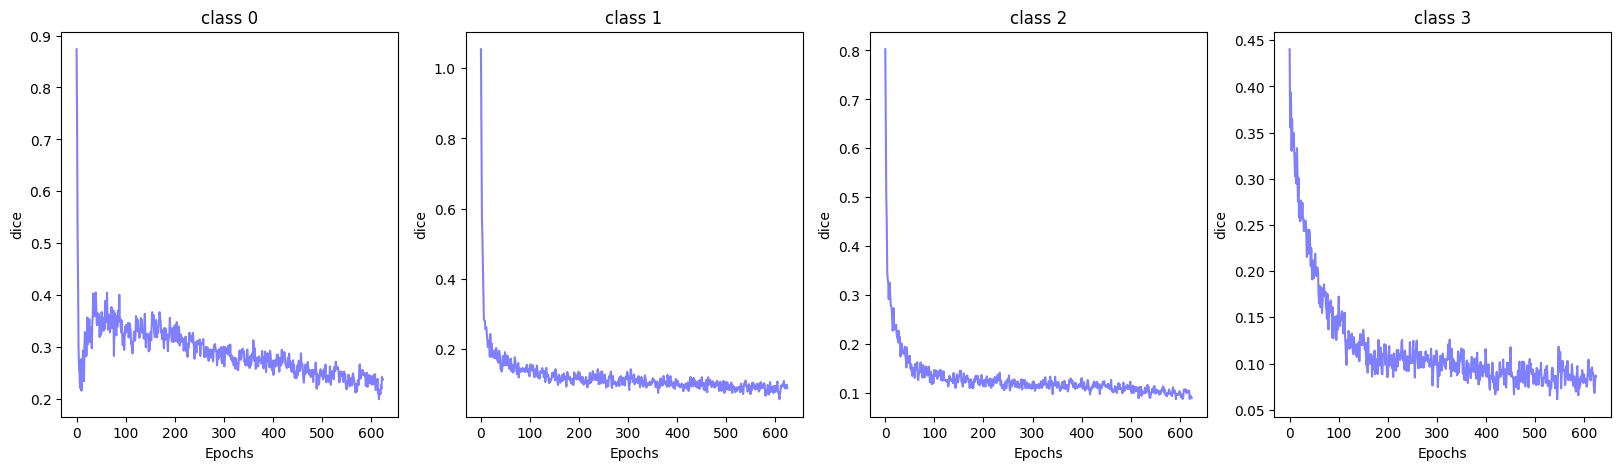

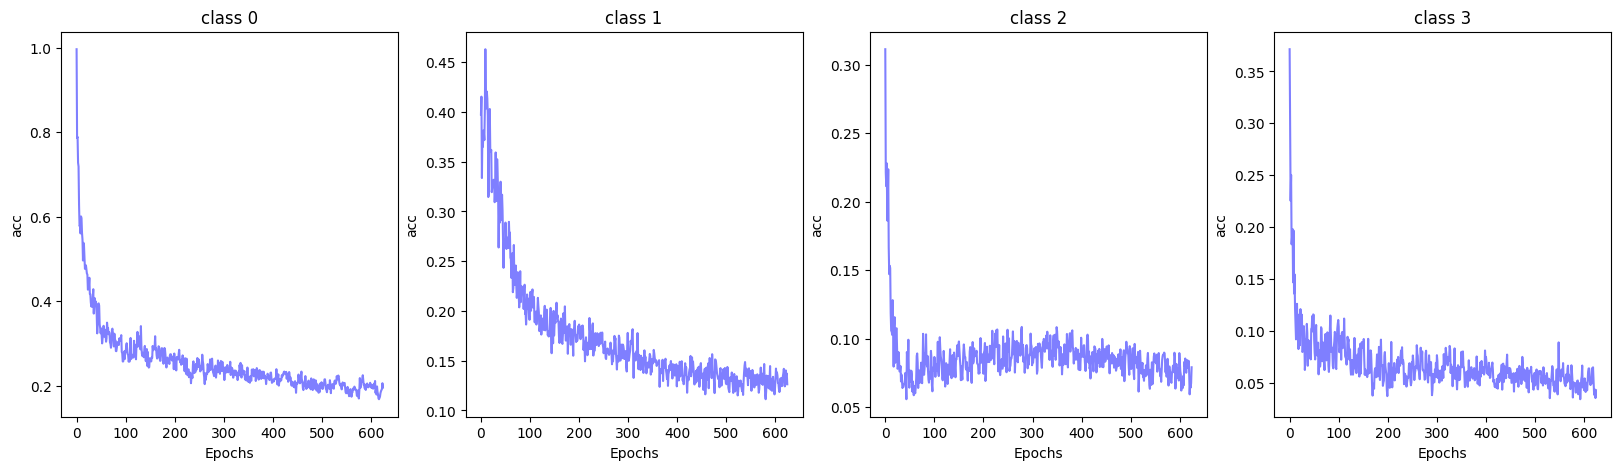

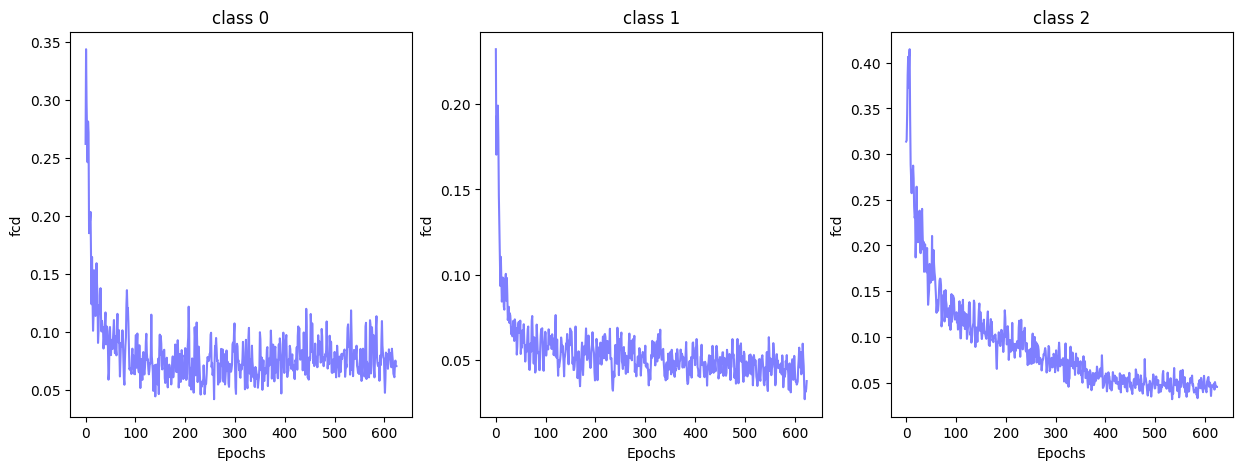

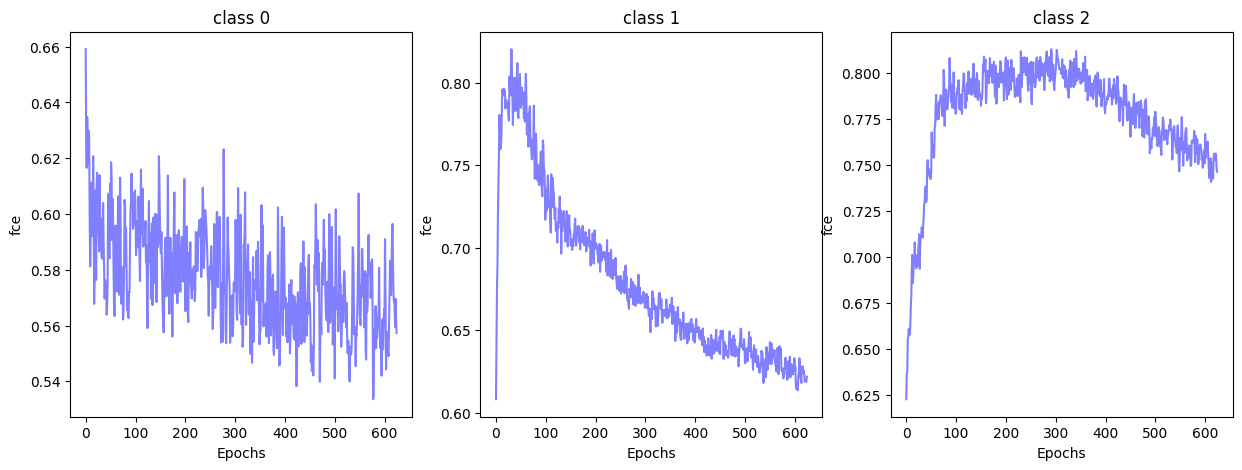

In [158]:
for cache_key in caches:
    n_plots = caches[cache_key].shape[2]
    score_data = caches[cache_key].detach().cpu()
    last_dim = score_data.shape[2]
    score_data = score_data.view(-1, 128, 1, last_dim).mean(1)
    fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 5, 5))

    for i in range(n_plots):
        axes[i].plot(score_data[:, :, i].mean(1),  c='b', alpha=0.5)
        # axes[i].plot(score_data[:, :, i].amin(1),  c='r', alpha=0.5, label='min')
        axes[i].set_title(f'class {i}')
        axes[i].set_xlabel('Epochs')
        # axes[i].legend()
        axes[i].set_ylabel(cache_key)

    plt.show()



In [54]:
wrapper_wohead = get_score_prediction_modification(
    swivels=swivels,
    unet=unet,
    adapter_output_dim=14,
    attach_prediction_head=False,
    transform=False,
    lr=1e-6,
)

loss_cache_individual = fit_score_prediction_modification(
    wrapper=wrapper_wohead, 
    dataloader=train_loader,
    prediction_head=False,
    scores=['dice', 'acc', 'fcd', 'fce'], # 'fcd', 'fce'],
    epochs=2500,
    lr=1e-6
)

dice: 5.8978 |acc: 5.6768 |fcd: 4.2341 |fce: 14.5465 | Progress: 100%|██████████| 2500/2500 [18:39<00:00,  2.23it/s]  


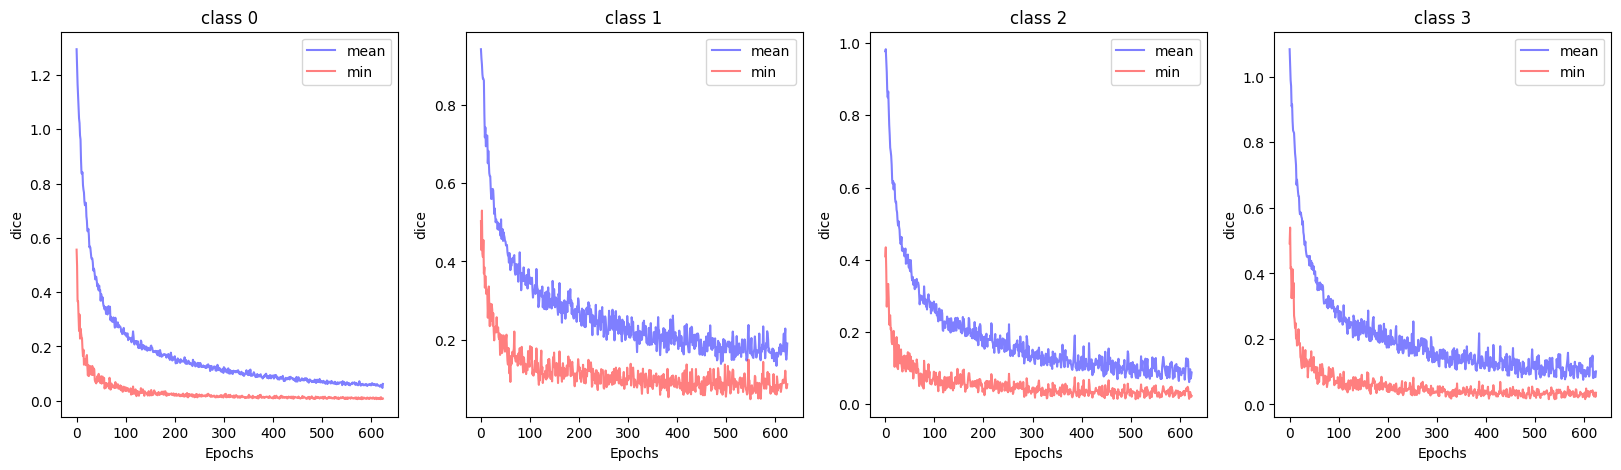

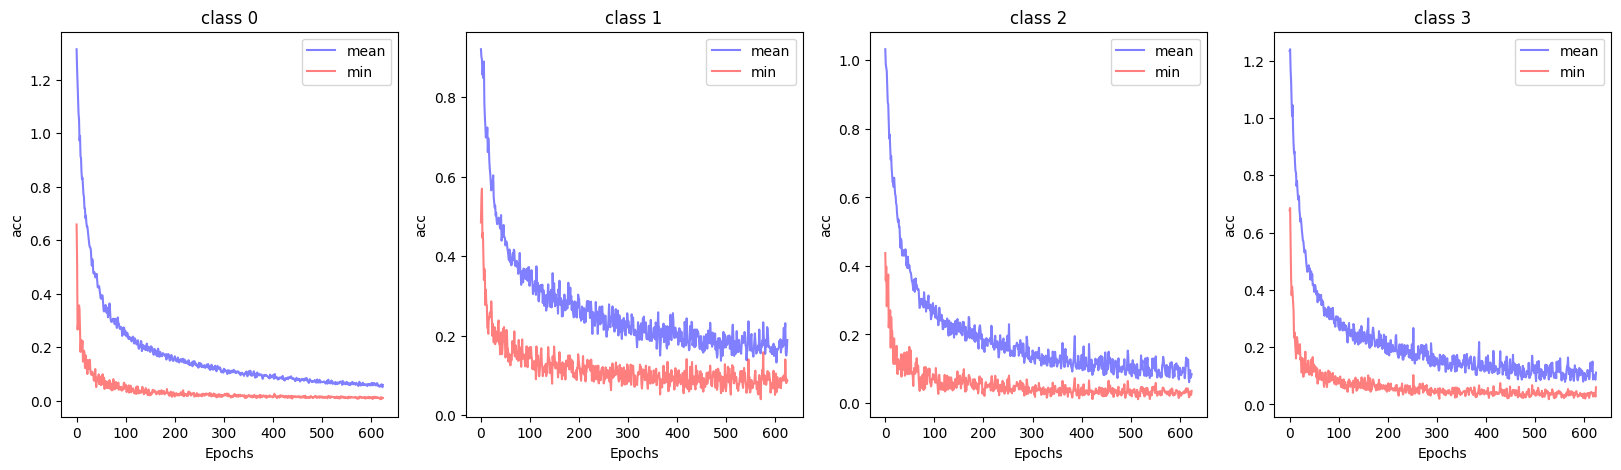

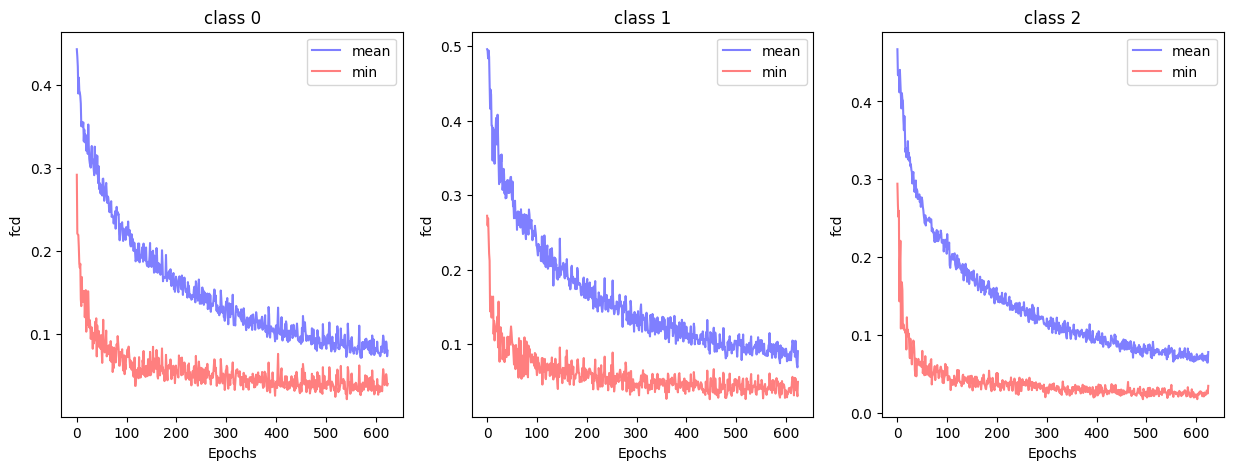

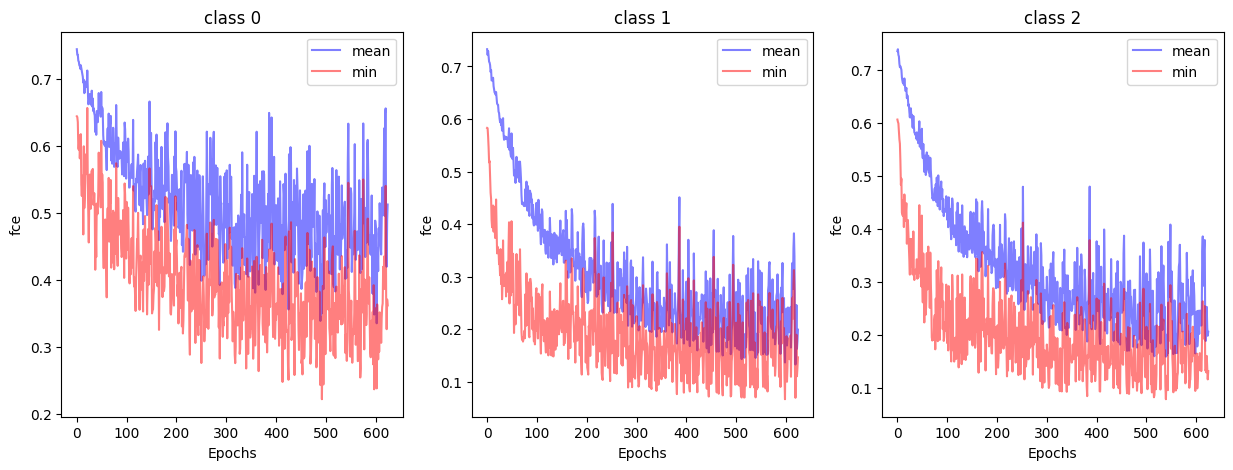

In [159]:
caches_nohead = {
    'dice': torch.cat([l['dice'] for l in loss_cache_individual], dim=0),
    'acc': torch.cat([l['acc'] for l in loss_cache_individual], dim=0),
    'fcd': torch.cat([l['fcd'] for l in loss_cache_individual], dim=0),
    'fce': torch.cat([l['fce'] for l in loss_cache_individual], dim=0)
}

for cache_key in caches_nohead:
    n_plots = caches_nohead[cache_key].shape[2]
    score_data = caches_nohead[cache_key].detach().cpu()
    last_dim = score_data.shape[2]
    score_data = score_data.view(-1, 128, 45, last_dim).mean(1)
    fig, axes = plt.subplots(1, n_plots, figsize=(n_plots * 5, 5))

    for i in range(n_plots):
        axes[i].plot(score_data[:, :, i].mean(1),  c='b', alpha=0.5, label='mean')
        axes[i].plot(score_data[:, :, i].amin(1),  c='r', alpha=0.5, label='min')
        axes[i].set_title(f'class {i}')
        axes[i].set_xlabel('Epochs')
        axes[i].legend()
        axes[i].set_ylabel(cache_key)

    plt.show()

In [160]:
def cumulative_counts(idxs, num_classes):
    """
    Compute the cumulative counts of indices over time.

    Args:
        idxs (torch.Tensor): Tensor of shape (T, top_k) containing indices at each time step.
        num_classes (int): Total number of possible indices (N).

    Returns:
        torch.Tensor: Tensor of shape (T, N) containing cumulative counts for each index over time.
    """
    T = idxs.size(0)
    counts = torch.zeros(T, num_classes, dtype=torch.long)

    for t in range(T):
        counts_t = torch.bincount(idxs[t], minlength=num_classes)
        counts[t] += counts_t


    cumulative_counts = counts.cumsum(dim=0)
    return cumulative_counts

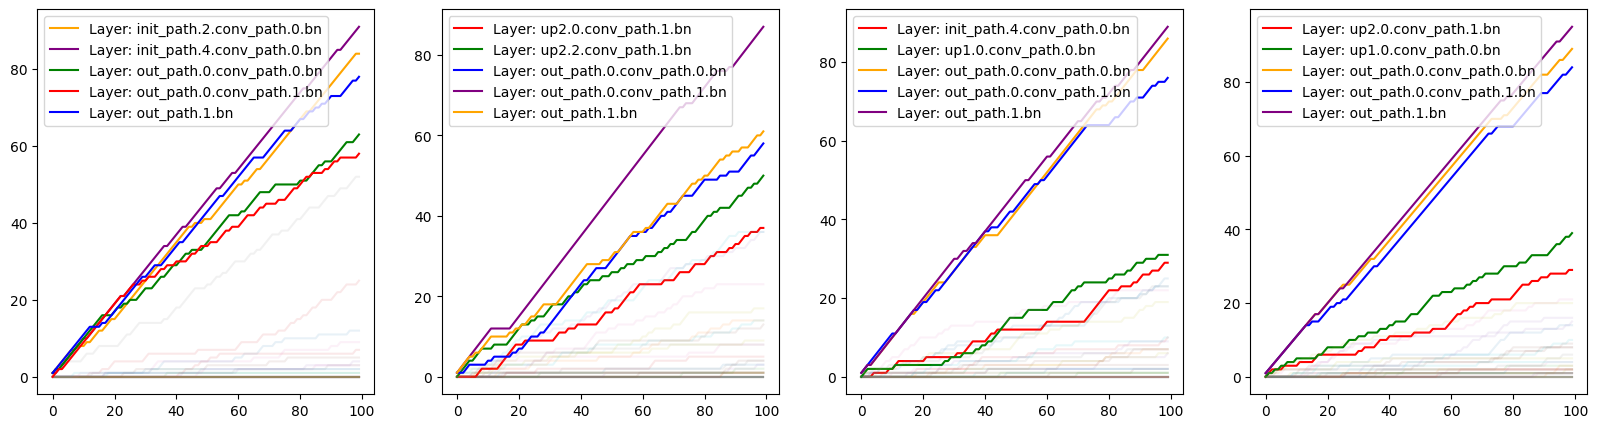

In [173]:
score_key = 'dice'
n_classes_for_score = 4


score_data = caches_nohead[score_key].detach().cpu()
# score_data = caches_nohead['dice'].detach().cpu()[-512:]


score_data = score_data.view(-1, 32, 45, n_classes_for_score).mean(1)[-100:] #[-512:]
colors = ['red', 'green', 'blue', 'orange', 'purple']

fig, axes = plt.subplots(1, n_classes_for_score, figsize=(n_classes_for_score * 5, 5))

for i in range(n_classes_for_score):

    top5 = score_data[:, :, i].argsort(1)[:, :5]
    classes = top5.unique()
    n_classes = max(classes) + 1
    t = cumulative_counts(top5, n_classes)

    label_indices = t[-1].argsort()[-5:]
    value_color_dict = {value: color for value, color in zip(label_indices.numpy(), colors)}

    for j in range(t.shape[1]):
        if j in label_indices:
            axes[i].plot(t[:, j], label=f'Layer: {wrapper_wohead.adapters[j].swivel}', color=value_color_dict[j])
        else:
            axes[i].plot(t[:, j], alpha=0.1)
    axes[i].legend()

    # plt.show()



In [182]:

def eval_score_prediction_modification(
    wrapper: nn.Module,
    dataloader: DataLoader,
    prediction_head: bool,
    num_classes: int = 4,
    device: str = 'cuda',
    scores: List[str] = ['dice', 'acc', 'fcd', 'fce'],
):

    loss_collection = LossCollection()
    metrics = {
        'gt': {k: [] for k in scores},
        'pred': {k: [] for k in scores},
    }


    # progress_bar = tqdm(range(len()), total=epochs, position=0, leave=True)
    for batch in dataloader:
        input  = batch['input'].to(device)
        target = batch['target'].long().to(device)
        target[target == -1] = 0
        logits = wrapper(input)
        preds = argmax(logits, dim=1, keepdim=True)
        if prediction_head:
            prediction = wrapper.prediction.unsqueeze(1)
        else:
            prediction = wrapper.output_per_adapter


        if 'dice' in scores:
            metrics['gt']['dice'].append(stack([
                dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=num_classes,
                    zero_division=1,
                    average='none'
                ) for s,t in zip(preds, target)
            ]).cpu().detach().nan_to_num(0).unsqueeze(1).repeat(1, prediction.shape[1], 1))
            metrics['pred']['dice'].append(prediction[:, :, :4].cpu())
                
        if 'acc' in scores:
            metrics['gt']['acc'].append(stack([
                    multiclass_accuracy(
                        s.flatten(), 
                        t.flatten(),
                        num_classes=num_classes,
                        average='none'
                    ) for s,t in zip(preds, target)
                ]).cpu().detach().unsqueeze(1).repeat(1, prediction.shape[1], 1))
            metrics['pred']['acc'].append(prediction[:, :, 4:8].cpu())

        if 'fcd' in scores:
            metrics['gt']['fcd'].append(stack(
                [(target == i).sum((1,2,3)) / (target>=1).sum((1,2,3)) for i in range(1, num_classes)],
                dim=1
            ).cpu().nan_to_num(0.0).unsqueeze(1).repeat(1, prediction.shape[1], 1))
            metrics['pred']['fcd'].append(prediction[:, :, 8:11].cpu())

        if 'fce' in scores:
            metrics['gt']['fce'].append(stack(
                [(target == i).any((1,2,3)) for i in range(1, num_classes)],
                dim=1
            ).cpu().float().unsqueeze(1).repeat(1, prediction.shape[1], 1))
            metrics['pred']['fce'].append(sigmoid(prediction[:, :, 11:14]).cpu())

    return metrics



In [183]:
dataloader = DataLoader(data['A'], batch_size=32, shuffle=False, drop_last=False)
metrics = eval_score_prediction_modification(
    wrapper_wohead,
    dataloader=dataloader,
    prediction_head=False,
    num_classes=4,
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 44.35 GiB of which 57.69 MiB is free. Process 250015 has 44.28 GiB memory in use. Of the allocated memory 43.89 GiB is allocated by PyTorch, and 45.95 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

set